## Import core libraries

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from tqdm import tqdm


## EDA

**Clearify path**

In [20]:
TRAIN_PATH = "../../database/train"        # train + validation
TEST_PATH  = "../../database/test"

In [21]:
BATCH_SIZE = 64
EPOCHS = 35
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [22]:
KHMER_DIGITS = {
    0: "០", 1: "១", 2: "២", 3: "៣", 4: "៤",
    5: "៥", 6: "៦", 7: "៧", 8: "៨", 9: "៩"
}

In [23]:
classes = sorted(os.listdir(TRAIN_PATH))
print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 10


In [24]:
class_counts = []
total_images = 0

for cls in classes:
    count = len(os.listdir(os.path.join(TRAIN_PATH, cls)))
    class_counts.append(count)
    total_images += count
    print(f"Class {cls}: {count} images")

print("Total images:", total_images)

Class 0: 300 images
Class 1: 300 images
Class 2: 300 images
Class 3: 300 images
Class 4: 300 images
Class 5: 300 images
Class 6: 300 images
Class 7: 300 images
Class 8: 300 images
Class 9: 300 images
Total images: 3000


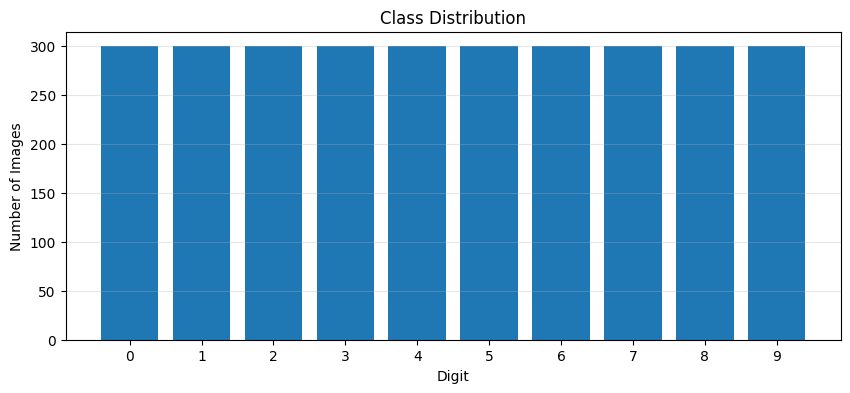

In [25]:
plt.figure(figsize=(10, 4))
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Number of Images")
plt.grid(axis="y", alpha=0.3)
plt.show()


## Inspect raw image statistics

Shape: (222, 170)
Min: 0 Max: 255


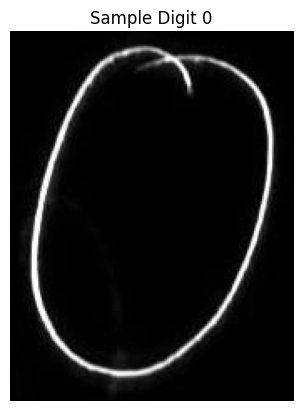

In [26]:
sample_cls = classes[0]
sample_img_path = os.path.join(
    TRAIN_PATH, sample_cls, os.listdir(os.path.join(TRAIN_PATH, sample_cls))[0]
)

img = plt.imread(sample_img_path)

print("Shape:", img.shape)
print("Min:", img.min(), "Max:", img.max())

plt.imshow(img, cmap="gray")
plt.title(f"Sample Digit {sample_cls}")
plt.axis("off")
plt.show()


In [27]:
dims = Counter()

for cls in classes:
    for f in os.listdir(os.path.join(TRAIN_PATH, cls)):
        img = plt.imread(os.path.join(TRAIN_PATH, cls, f))
        dims[img.shape] += 1

print("Image dimensions:")
for k, v in dims.items():
    print(k, ":", v)

Image dimensions:
(222, 170) : 1
(64, 64, 4) : 1500
(143, 99) : 1
(176, 124) : 1
(431, 381) : 1
(270, 190) : 1
(122, 98) : 2
(224, 186) : 1
(115, 101) : 1
(126, 90) : 1
(99, 79) : 2
(251, 206) : 1
(162, 123) : 1
(255, 196) : 1
(265, 220) : 1
(157, 117) : 1
(112, 88) : 1
(436, 335) : 1
(106, 71) : 1
(170, 125) : 1
(135, 79) : 1
(260, 222) : 1
(128, 102) : 5
(261, 227) : 1
(110, 88) : 1
(246, 177) : 1
(176, 99) : 1
(148, 112) : 1
(274, 214) : 1
(130, 84) : 1
(130, 93) : 1
(157, 128) : 1
(186, 131) : 1
(267, 243) : 1
(323, 195) : 1
(106, 85) : 1
(255, 133) : 1
(161, 110) : 1
(154, 91) : 1
(201, 156) : 1
(146, 117) : 2
(261, 235) : 1
(188, 145) : 1
(183, 131) : 1
(250, 189) : 1
(290, 232) : 1
(177, 93) : 1
(261, 239) : 1
(134, 96) : 2
(253, 217) : 1
(112, 90) : 2
(246, 228) : 1
(124, 85) : 1
(290, 201) : 1
(108, 74) : 1
(123, 98) : 4
(120, 96) : 3
(121, 97) : 1
(100, 100) : 1
(250, 247) : 1
(162, 109) : 1
(283, 202) : 1
(117, 74) : 1
(249, 201) : 1
(270, 244) : 1
(113, 82) : 1
(177, 113) :

## Preprocessing

In [65]:
def preprocess_lenet(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize
    img = img.astype(np.float32) / 255.0

    # threshold only for bbox
    bw = (img > 0.1).astype(np.uint8) * 255

    coords = cv2.findNonZero(bw)
    if coords is None:
        return np.zeros((28, 28), dtype=np.float32)  # Changed: return 2D numpy

    x,y,w,h = cv2.boundingRect(coords)

    # add margin
    pad = int(0.2 * max(w,h))
    x0 = max(x-pad, 0)
    y0 = max(y-pad, 0)
    x1 = min(x+w+pad, img.shape[1])
    y1 = min(y+h+pad, img.shape[0])

    digit = img[y0:y1, x0:x1]

    # resize digit to fill frame
    digit = cv2.resize(digit, (28,28), interpolation=cv2.INTER_AREA)

    return digit  

In [66]:
class KhmerDigitDataset(Dataset):
    def __init__(self, samples, augment=False):
        self.samples = samples
        self.augment = augment

        self.aug = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            ),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = preprocess_lenet(img)  # returns 28x28 float

        if self.augment:
            img = self.aug(img)
        else:
            img = torch.tensor(img).unsqueeze(0)

        return img, label


In [67]:
all_samples = []
for label in sorted(os.listdir(TRAIN_PATH)):
    for img_name in os.listdir(os.path.join(TRAIN_PATH, label)):
        all_samples.append(
            (os.path.join(TRAIN_PATH, label, img_name), int(label))
        )

np.random.shuffle(all_samples)

train_size = int(0.85 * len(all_samples))
train_samples = all_samples[:train_size]
val_samples   = all_samples[train_size:]

train_ds = KhmerDigitDataset(train_samples, augment=True)
val_ds   = KhmerDigitDataset(val_samples, augment=False)

test_samples = []
for label in sorted(os.listdir(TEST_PATH)):
    for img_name in os.listdir(os.path.join(TEST_PATH, label)):
        test_samples.append(
            (os.path.join(TEST_PATH, label, img_name), int(label))
        )

test_ds = KhmerDigitDataset(test_samples, augment=False)


In [68]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)


**LeNet Network**

In [69]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [70]:
model = LeNetBN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1} | Val Acc: {100*correct/total:.2f}%")


Epoch 1 | Val Acc: 88.00%
Epoch 2 | Val Acc: 95.56%
Epoch 3 | Val Acc: 98.89%
Epoch 4 | Val Acc: 99.56%
Epoch 5 | Val Acc: 99.78%
Epoch 6 | Val Acc: 97.33%
Epoch 7 | Val Acc: 98.89%
Epoch 8 | Val Acc: 99.78%
Epoch 9 | Val Acc: 100.00%
Epoch 10 | Val Acc: 99.56%
Epoch 11 | Val Acc: 99.11%
Epoch 12 | Val Acc: 100.00%
Epoch 13 | Val Acc: 99.78%
Epoch 14 | Val Acc: 99.33%
Epoch 15 | Val Acc: 99.78%
Epoch 16 | Val Acc: 99.78%
Epoch 17 | Val Acc: 99.56%
Epoch 18 | Val Acc: 99.33%
Epoch 19 | Val Acc: 99.78%
Epoch 20 | Val Acc: 99.56%
Epoch 21 | Val Acc: 99.56%
Epoch 22 | Val Acc: 100.00%
Epoch 23 | Val Acc: 99.78%
Epoch 24 | Val Acc: 100.00%
Epoch 25 | Val Acc: 99.78%
Epoch 26 | Val Acc: 99.33%
Epoch 27 | Val Acc: 99.78%
Epoch 28 | Val Acc: 100.00%
Epoch 29 | Val Acc: 100.00%
Epoch 30 | Val Acc: 99.78%


In [71]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Train Accuracy: {100*correct/total:.2f}%")


Train Accuracy: 98.39%


In [72]:
def predict_one(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # USE THE SAME PREPROCESSING AS TRAINING
    img = preprocess_lenet(img)   # <--- critical

    img = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img)
        probs = torch.softmax(output, dim=1)
        pred = probs.argmax().item()
        conf = probs.max().item()

    return pred, KHMER_DIGITS[pred], conf


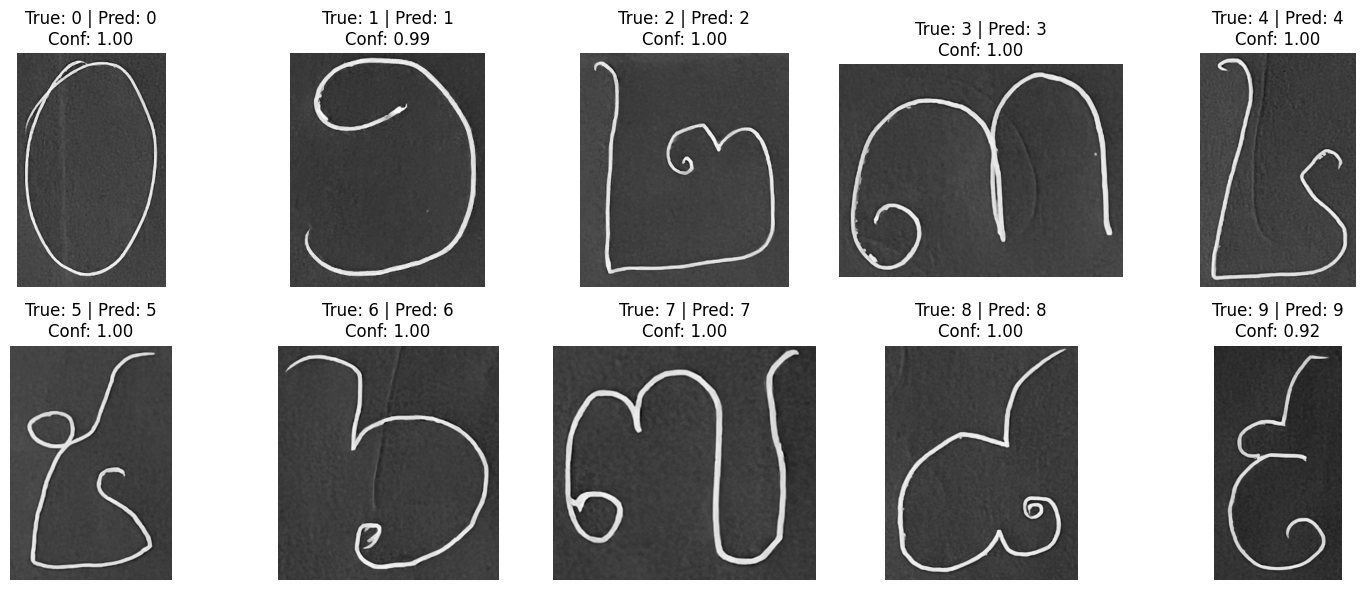

In [73]:
plt.figure(figsize=(15, 6))

idx = 1
for digit in range(10):
    class_dir = os.path.join(TEST_PATH, str(digit))
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)

    pred, _, conf = predict_one(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, idx)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {digit} | Pred: {pred}\nConf: {conf:.2f}")
    plt.axis("off")

    idx += 1

plt.tight_layout()
plt.show()


**save model**

In [74]:
os.makedirs("../../api/model/lenet", exist_ok=True)
torch.save(model.state_dict(), "../../api/model/lenet/lenet.pth")

print("Model exported successfully!")

Model exported successfully!
